# IMPORTS

In [90]:
import gc
import json
import re

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from markdown_it import MarkdownIt

import importlib
import utils
import datetime
import os

importlib.reload(utils)

[nltk_data] Downloading package punkt_tab to /home/cg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<module 'utils' from '/home/cg/Documents/UNIVERSITÀ/DEEP LEARNING/utils.py'>

# DATA CLEANING

### Instantiate variables

In [91]:
# --- CONFIGURATION ---
INPUT_CSV_MSG = "DATA/mod_progress_messages.csv"
OUTPUT_CSV_MSG = "DATA/mod_progress_messages_clean.csv"
INPUT_CSV_PROGRESS = "DATA/mod_progress.csv"
OUTPUT_CSV_PROGRESS = "DATA/mod_progress_clean.csv"

OUTPUT_JSON = "DATA/progress_dataset_dedup.json"
SIMILARITY_THRESHOLD = 0.95  # Cosine similarity above which we treat messages as duplicates

INDEX_PATH = "RAG/faiss_index"
METADATA_PATH = "RAG/rag_metadata"
EMBEDDING_MODELS = [
    "all-MiniLM-L6-v2",
    # "nomic-ai/nomic-embed-text-v1.5",
    "multi-qa-distilbert-cos-v1",
    "multi-qa-mpnet-base-dot-v1"
]

### Create cleaned csv files from the original ones

In [92]:
# --- CLEANING FUNCTION ---
def clean_html(raw_html):
    # Remove HTML tags and decode HTML entities
    soup = BeautifulSoup(str(raw_html), "html.parser")
    text = soup.get_text()
    # Remove links
    text = re.sub(r"http\S+|www\S+", "", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# If clean files already exist, skip cleaning
try:
    df_msgs = pd.read_csv(OUTPUT_CSV_MSG)
    print("Messages CSV already exists. Skipping cleaning.")
except FileNotFoundError:
    print("Messages CSV not found. Proceeding with cleaning.")
    # --- LOAD & CLEAN ---
    df_msgs = pd.read_csv(INPUT_CSV_MSG)

    # Apply cleaning
    df_msgs["clean_text"] = df_msgs["tText"].apply(clean_html)

    # Filter out empty or too short messages
    df_msgs = df_msgs[df_msgs["clean_text"].str.len() > 10]

    df_msgs = df_msgs.drop(columns=["tText"])

    # --- PREP ---
    df_msgs = df_msgs.rename(columns={
        "iId": "message_id",
        "iProgressId": "progress_id",
        "iMessageFatherId": "answer_to_message_id",
        "clean_text": "content",
        "Field73": "author",
        "dDate": "timestamp",
        "sAttachment": "attachment"
    })[["message_id", "progress_id", "answer_to_message_id", "author", "timestamp", "content", "attachment"]]

    # Save result
    df_msgs.to_csv(OUTPUT_CSV_MSG, index=False, encoding="utf-8", errors="replace")

    print("Messages cleaning complete. Saved to", OUTPUT_CSV_MSG)
    print(df_msgs[["message_id", "progress_id", "author", "timestamp", "content"]].head())

try:
    df_progress = pd.read_csv(OUTPUT_CSV_PROGRESS)
    print("Progress CSV already exists. Skipping cleaning.")
except FileNotFoundError:
    print("Progress CSV not found. Proceeding with cleaning.")
    df_progress = pd.read_csv(INPUT_CSV_PROGRESS)

    df_progress["clean_description"] = df_progress["sDescription"].apply(clean_html)

    df_progress = df_progress.drop(columns=["sDescription"])

    df_progress = df_progress.rename(columns={
        "iId": "progress_id",
        "sTitle": "subject",
        "clean_description": "description",
        "sAuthor": "author",
        "dOpen": "created_at",
        "dClose": "closed_at",
        "dLastChange": "updated_at"
    })[["progress_id", "subject", "description", "author", "created_at", "closed_at", "updated_at"]]

    df_progress.to_csv(OUTPUT_CSV_PROGRESS, index=False, encoding="utf-8", errors="replace")

    print("Progress cleaning complete. Saved to", OUTPUT_CSV_PROGRESS)
    print(df_progress[["progress_id", "author", "created_at", "description"]].head())


Messages CSV already exists. Skipping cleaning.
Progress CSV already exists. Skipping cleaning.


### Create JSON dataset

In [93]:
# If JSON dataset already exists, skip processing

try:
    with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
        dataset = json.load(f)
    print("JSON dataset already exists. Skipping processing.")
except FileNotFoundError:
    print("JSON dataset not found. Proceeding with processing.")
    # --- GROUP MESSAGES BY PROGRESS ID ---
    grouped = df_msgs.groupby("progress_id")

    print(grouped.size().describe())

    dataset = []

    num_of_removed = 0
    skipped_progress_empty_metadata = 0

    for progress_id, group in grouped:
        messages = group.sort_values("timestamp").to_dict(orient="records")
        texts = [msg["content"] for msg in messages]

        # TF-IDF deduplication
        if len(texts) > 1:
            tfidf = TfidfVectorizer().fit_transform(texts)
            sim_matrix = cosine_similarity(tfidf)
            to_remove = set()
            for i in range(len(messages)):
                for j in range(i + 1, len(messages)):
                    if sim_matrix[i, j] >= SIMILARITY_THRESHOLD:
                        to_remove.add(j)  # keep earlier msg (i), discard later (j)
            num_of_removed += len(to_remove)
            messages = [msg for idx, msg in enumerate(messages) if idx not in to_remove]

        # Metadata
        unique_authors = set(msg["author"] for msg in messages)
        total_length = sum(len(msg["content"]) for msg in messages)

        progress_info = df_progress[df_progress["progress_id"] == progress_id]
        if progress_info.empty:
            skipped_progress_empty_metadata += 1
            continue
        meta = progress_info.iloc[0].to_dict()

        dataset.append({
            "progress_id": progress_id,
            "subject": meta["subject"],
            "description": meta["description"],
            "created_at": meta["created_at"],
            "closed_at": meta["closed_at"],
            "updated_at": meta["updated_at"],
            "author": meta["author"],
            "message_count": len(messages),
            "total_char_length": total_length,
            "distinct_authors": len(unique_authors),
            "messages": messages
        })

    print(f"Processed {len(dataset)} progress threads and {len(df_msgs)} messages with {num_of_removed} duplicates removed.")
    print(f"Removed {skipped_progress_empty_metadata} progress threads present in messages but missing metadata.")

    # Remove progress threads with no messages

    dataset = [p for p in dataset if p["message_count"] > 0]

    # --- SAVE OUTPUT ---
    with open(OUTPUT_JSON, "w", encoding="utf-8", errors="replace") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=2)

    print(f"Saved structured JSON to {OUTPUT_JSON}")


JSON dataset already exists. Skipping processing.


# DATA ANALYSIS

In [94]:
# Load structured JSON
with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
    dataset = json.load(f)

df_progress_analysis = pd.DataFrame([{
    "progress_id": p["progress_id"],
    "subject": p["subject"],
    "description": p.get("description", ""),
    "created_at": p["created_at"],
    "closed_at": p.get("closed_at", None),
    "updated_at": p["updated_at"],
    "author": p["author"],
    "message_count": p["message_count"],
    "total_char_length": p["total_char_length"],
    "distinct_authors": p["distinct_authors"]
} for p in dataset])

df_progress_analysis.head()

# Flatten messages for DataFrame-like manipulation

flat_messages = []
for prog in dataset:
    for msg in prog["messages"]:
        flat_messages.append({
            "progress_id": prog["progress_id"],
            "progress_title": prog["subject"],
            "progress_created_at": prog["created_at"],
            "message_id": msg["message_id"],
            "timestamp": msg["timestamp"],
            "author": msg["author"],
            "content": msg["content"]
        })

df_messages_analysis = pd.DataFrame(flat_messages)
df_messages_analysis.head()

# Convert dates to datetime
df_progress_analysis["created_at"] = pd.to_datetime(df_progress_analysis["created_at"], errors="coerce")
df_progress_analysis["closed_at"] = pd.to_datetime(df_progress_analysis["closed_at"], errors="coerce")
df_progress_analysis["updated_at"] = pd.to_datetime(df_progress_analysis["updated_at"], errors="coerce")

df_messages_analysis["timestamp"] = pd.to_datetime(df_messages_analysis["timestamp"], errors="coerce")

# Basic info
print("Messages shape:", df_messages_analysis.shape)
print("Progress shape:", df_progress_analysis.shape)

Messages shape: (8750, 7)
Progress shape: (690, 10)


## Basic statistics

Unique progress threads: 690
Messages per thread (summary):
count     690.000000
mean       12.681159
std        57.849460
min         1.000000
25%         2.000000
50%         3.000000
75%         8.000000
max      1152.000000
Name: message_count, dtype: float64


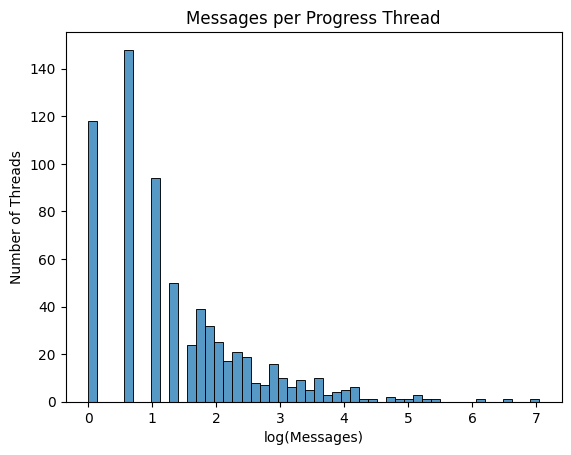

In [95]:
# Number of unique progress threads
n_threads = df_progress_analysis.shape[0]
print("Unique progress threads:", n_threads)

# Messages per thread
messages_per_thread = df_progress_analysis["message_count"]
print("Messages per thread (summary):")
print(messages_per_thread.describe())

# Plot num of messages in log scale because of skewed distribution
sns.histplot(np.log(messages_per_thread), bins=50, kde=False)
plt.title("Messages per Progress Thread")
plt.xlabel("log(Messages)")
plt.ylabel("Number of Threads")
plt.show()


Message length (chars) summary:
count     8750.000000
mean       811.777371
std       1797.593518
min         11.000000
25%        109.000000
50%        296.000000
75%        812.750000
max      66328.000000
Name: msg_length, dtype: float64


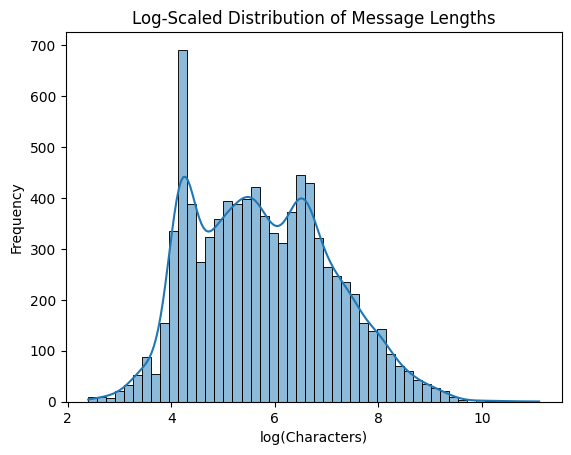

Unique authors: 49


In [96]:
# Message lengths
df_messages_analysis["msg_length"] = df_messages_analysis["content"].str.len()
print("Message length (chars) summary:")
print(df_messages_analysis["msg_length"].describe())

# Plot message lengths in log scale because of skewed distribution
sns.histplot(np.log(df_messages_analysis["msg_length"]), bins=50, kde=True)
plt.title("Log-Scaled Distribution of Message Lengths")
plt.xlabel("log(Characters)")
plt.ylabel("Frequency")
plt.show()

# Number of unique authors
n_authors = df_messages_analysis["author"].nunique()
print("Unique authors:", n_authors)


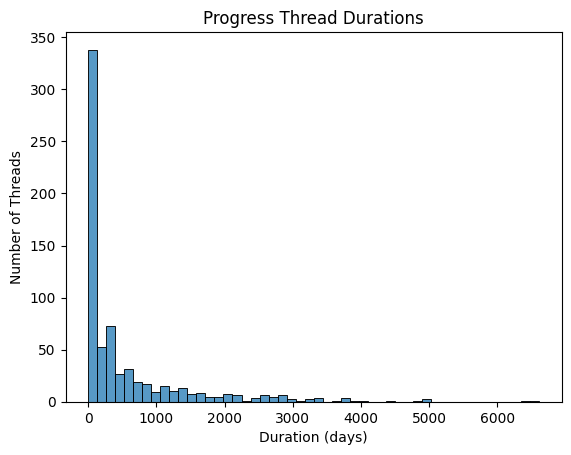

count     690.000000
mean      554.339140
std       939.268082
min         0.000000
25%         0.030084
50%       151.454369
75%       639.493070
max      6610.008449
Name: duration_days, dtype: float64

In [97]:
# Thread durations (min → max message timestamp per thread)
thread_times = df_messages_analysis.groupby("progress_id")["timestamp"].agg(["min", "max"])
thread_times["duration_days"] = (thread_times["max"] - thread_times["min"]).dt.total_seconds() / (3600 * 24)

# Plot
sns.histplot(thread_times["duration_days"], bins=50, kde=False)
plt.title("Progress Thread Durations")
plt.xlabel("Duration (days)")
plt.ylabel("Number of Threads")
plt.show()

thread_times["duration_days"].describe()


# RAG

### Load and process messages for RAG

In [98]:
# --- LOAD AND FLATTEN JSON WITH CONTEXT ---
with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
    dataset = json.load(f)

flat_messages = []
for progress in dataset:
    progress_subject = progress.get("subject", "")
    progress_description = progress.get("description", "")
    for msg in progress["messages"]:
        enriched_content = (
            f"[Progress Title: {progress_subject}]\n\n"
            f"[Progress Description: {progress_description.strip()}]\n\n"
            f"{msg['content'].strip()}"
        )
        flat_messages.append({
            "progress_id": progress["progress_id"],
            "progress_title": progress_subject,
            "progress_description": progress_description,
            "message_id": msg["message_id"],
            "timestamp": msg["timestamp"],
            "author": msg["author"],
            "original_content": msg["content"],
            "enriched_content": enriched_content
        })

df = pd.DataFrame(flat_messages)
df = df.dropna(subset=["enriched_content"])
df = df[df["enriched_content"].str.len() > 10].reset_index(drop=True)

# --- EMBEDDINGS ---

model = None
embeddings = None

for model_name in EMBEDDING_MODELS:
    index_path = INDEX_PATH + "_" + model_name.replace("/", "_")
    metadata_path = METADATA_PATH + "_" + model_name.replace("/", "_")

    # If index and metadata already exist, skip processing

    if faiss.read_index(INDEX_PATH + "_" + model_name.replace("/", "_") + ".index") and \
            pd.io.json.read_json(METADATA_PATH + "_" + model_name.replace("/", "_") + ".json").shape[0] > 0:
        print(f"Index and metadata for {model_name} already exist. Skipping processing.")
        continue

    print("Loading embedding model:", model_name)
    model = SentenceTransformer(model_name, trust_remote_code=True)
    print("Encoding enriched messages...")
    embeddings = model.encode(df["enriched_content"].tolist(), show_progress_bar=True, convert_to_numpy=True)

    # --- FAISS INDEXING ---
    print("Building FAISS index...")
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)

    # Save FAISS index
    faiss.write_index(index, index_path + ".index")
    print(f"FAISS index saved to {index_path}.index")

    # Save metadata
    df.to_json(metadata_path + ".json", orient="records", force_ascii=False, indent=2)
    print(f"Metadata saved to {metadata_path}.json")

# --- Unload model and free GPU memory ---

if model is not None:
    del model
    del embeddings
    del index
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Index and metadata for all-MiniLM-L6-v2 already exist. Skipping processing.
Index and metadata for multi-qa-distilbert-cos-v1 already exist. Skipping processing.
Index and metadata for multi-qa-mpnet-base-dot-v1 already exist. Skipping processing.


### Load and test FAISS index

In [99]:
def load_index_and_metadata(model_name):
    idx_path = f"{INDEX_PATH}_{model_name.replace('/', '_')}.index"
    meta_path = f"{METADATA_PATH}_{model_name.replace('/', '_')}.json"

    index = faiss.read_index(idx_path)
    df = pd.read_json(meta_path)
    return index, df

def retrieve_top_k(query, model, index, df, k=5):
    q_emb = model.encode([query])[0].astype("float32").reshape(1, -1)
    D, I = index.search(q_emb, k)
    return df.iloc[I[0]][["progress_title", "timestamp", "author", "original_content"]].to_dict(orient="records")

### Test retrieval with different models -> add test set

In [100]:
# for model_name in EMBEDDING_MODELS:
#     print(f"Testing model: {model_name}")
#     index, df = load_index_and_metadata(model_name)
#
#     # Test query
#     query = "cruscotto mim?"
#     results = retrieve_top_k(query, SentenceTransformer(model_name, trust_remote_code=True), index, df, k=5)
#
#     print(f"Top 5 results for query '{query}':")
#     for res in results:
#         print(f"- {res['progress_title']} by {res['author']} at {res['timestamp']}: {res['original_content'][:100]}...")  # Show first 100 chars

# Summaries generation

### PIPELINE IDEA 1
- If progress length is short enough → single summary
- If progress length is long → multiple summaries → make final summary from them

In [101]:
# Define the progress IDs for which you want to generate summaries
progress_ids_for_test = [
    1,
    # 660,
    # 678,
    # 5310,
    # 5311
]

# Load structured JSON
with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
    dataset = json.load(f)

df_dataset = pd.DataFrame([{
    "progress_id": p["progress_id"],
    "subject": p["subject"],
    "description": p.get("description", ""),
    "created_at": p["created_at"],
    "closed_at": p.get("closed_at", None),
    "updated_at": p["updated_at"],
    "author": p["author"],
    "message_count": p["message_count"],
    "total_char_length": p["total_char_length"],
    "distinct_authors": p["distinct_authors"],
    "messages": p["messages"]
} for p in dataset])

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for progress_id in progress_ids_for_test:
    print(f"Generating summary for progress ID: {progress_id}")

    row = df_dataset[df_dataset["progress_id"] == progress_id]
    if row.empty:
        print(f"No data found for progress ID {progress_id}. Skipping.")
        continue

    progress_data = row.iloc[0].to_dict()
    summary = utils.summarize_progress_idea_1(progress_data, llm="gemini", model="gemini-2.5-flash")

    # print(f"Summary for progress ID {progress_id}:\n{summary}\n")

    # Save summary in txt file

    dir_path = f"DATA/SUMMARIES/{timestamp}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    with open(f"{dir_path}/summary_progress_{progress_id}.txt", "w", encoding="utf-8") as f:
        f.write(summary)
    print(f"Summary saved to {dir_path}/summary_progress_{progress_id}.txt\n")

Generating summary for progress ID: 1
Summarizing directly...
Max length for summarization: 892 words.
Summary length: 739 words.
Summary saved to DATA/SUMMARIES/20250624_234915/summary_progress_1.txt



### PIPELINE IDEA 2
Organize progress threads into groups (annual, semi-annual, etc.) and summarize each group. Then union the summaries while maintaining chronological order.

In [102]:
# Define the progress IDs for which you want to generate summaries
progress_ids_for_test = [
    # 1,
    # 660,
    # 678,
    # 3771,
    # 5310,
    # 5311
]

# Load structured JSON
with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
    dataset = json.load(f)

df_dataset = pd.DataFrame([{
    "progress_id": p["progress_id"],
    "subject": p["subject"],
    "description": p.get("description", ""),
    "created_at": p["created_at"],
    "closed_at": p.get("closed_at", None),
    "updated_at": p["updated_at"],
    "author": p["author"],
    "message_count": p["message_count"],
    "total_char_length": p["total_char_length"],
    "distinct_authors": p["distinct_authors"],
    "messages": p["messages"]
} for p in dataset])

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for progress_id in progress_ids_for_test:
    print(f"Generating summary for progress ID: {progress_id}")

    row = df_dataset[df_dataset["progress_id"] == progress_id]
    if row.empty:
        print(f"No data found for progress ID {progress_id}. Skipping.")
        continue

    progress_data = row.iloc[0].to_dict()
    summary = utils.summarize_progress_idea_2(progress_data, llm="gemini", model="gemini-2.5-flash")

    # print(f"Summary for progress ID {progress_id}:\n{summary}\n")

    # Save summary in txt file

    dir_path = f"DATA/SUMMARIES/{timestamp}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

    with open(f"{dir_path}/summary_progress_{progress_id}.txt", "w", encoding="utf-8") as f:
        f.write(summary)
    print(f"Summary saved to {dir_path}/summary_progress_{progress_id}.txt\n")
